In [1]:
from io import BytesIO

import matplotlib.pyplot as plt
import requests
import torch
import torchvision.transforms as T
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
from PIL import ImageOps
from tqdm import tqdm
from utils import prepare_mask_and_masked_image
from utils import preprocess
from utils import recover_image

torch.backends.cuda.matmul.allow_tf32 = True


In [2]:
to_pil = T.ToPILImage()

### First lets instantiate an inpainting stable diffusion model

In [3]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details

pipe_inpaint: StableDiffusionInpaintPipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    # revision="fp16",
    torch_dtype=torch.float16,
)  # type: ignore
# pipe_inpaint = pipe_inpaint.to("cuda")
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe_inpaint.vae.fuse_qkv_projections()

# pipe_inpaint.vae._encode = torch.jit.script(pipe_inpaint.vae._encode)

pipe_inpaint.vae._encode = torch.compile(
    pipe_inpaint.vae._encode,
    fullgraph=True,
    mode="max-autotune",
    # backend="cudagraphs",
    # mode="reduce-overhead",
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### The image to immunize
Now let's load image + some mask so that we can inpaint the rest!

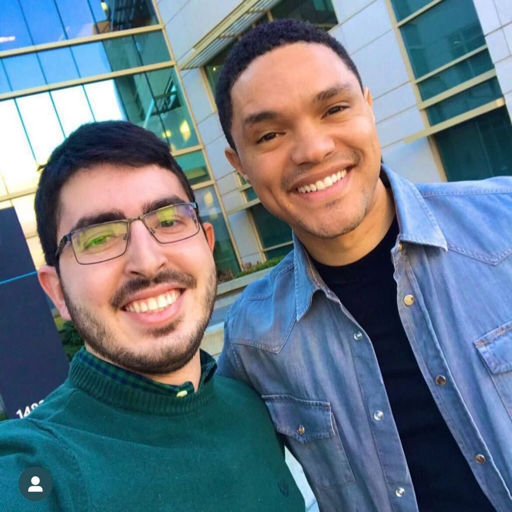

In [4]:
assets_path = "../../photoguard/assets"
init_image = Image.open(f"{assets_path}/trevor_5.jpg").convert('RGB').resize(
    (512, 512)
)
mask_image = Image.open(f"{assets_path}/trevor_5.tif").convert('RGB')
mask_image = ImageOps.invert(mask_image).resize((512, 512))

init_image

In [5]:
torch._dynamo.list_backends()

/home/jakub/miniconda3/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/jakub/miniconda3/envs/ml/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'tvm']

### Simple attack implementation
Now we implement a simple PGD attack 

In [ ]:
# @torch.compile(
#     fullgraph=True,
#     # mode="max-autotune",
#     # backend="cudagraphs",
#     mode="reduce-overhead",
# )
@torch.jit.script
def single_iteration(target: torch.Tensor, pred: torch.Tensor) -> torch.Tensor:
  return (pred - target).norm()


# @torch.compile(
#     fullgraph=True,
#     # mode="max-autotune",
#     # backend="cudagraphs",
#     mode="reduce-overhead",
# )
def update(
    x: torch.Tensor,
    grad: torch.Tensor,
    step: torch.Tensor,
    X_minus_eps: torch.Tensor,
    X_plus_eps: torch.Tensor,
    clamp_min: float,
    clamp_max: float,
) -> torch.Tensor:
  x = x - grad.sign() * step
  x = torch.clamp(x, min=X_minus_eps, max=X_plus_eps)
  x = torch.clamp(x, min=clamp_min, max=clamp_max)
  return x


def pgd(
    X,
    target,
    model,
    criterion,
    eps=0.1,
    step_size=0.015,
    iters=40,
    clamp_min=0,
    clamp_max=1,
    mask=None
):
  X_adv = X.clone().detach()
  # random_noise =
  X_adv.data += torch.rand_like(X_adv) * 2 * eps - eps

  pbar = tqdm(range(iters))
  X_minus_eps = (X - eps).detach()
  X_plus_eps = (X + eps).detach()

  for i in pbar:
    torch.compiler.cudagraph_mark_step_begin()

    actual_step_size = torch.tensor(
        step_size - (step_size - step_size / 100) / iters * i,
        dtype=X_adv.dtype,
        device=X_adv.device
    )
    X_adv.requires_grad_(True)
    loss = single_iteration(target, model(X_adv).latent_dist.mean)

    grad, = torch.autograd.grad(loss, [X_adv], retain_graph=False)

    # X_adv = X_adv.detach()  # don't compute gradient w.r.t. X_adv
    # X_adv = X_adv - grad.detach().sign() * actual_step_size
    # X_adv = torch.clamp(X_adv, min=X_minus_eps, max=X_plus_eps)
    # X_adv = torch.clamp(X_adv, min=clamp_min, max=clamp_max).detach()
    X_adv = update(
        X_adv, grad.detach(), actual_step_size, X_minus_eps, X_plus_eps,
        clamp_min, clamp_max
    ).detach()
    if mask is not None:
      X_adv.data *= mask
    X_adv.grad = None

    if i % 5 == 0:

      pbar.set_description(
          f"[Running attack]: step size: {actual_step_size:.4}"
      )
  return X_adv

### Target image
Here, different from the img2img notebook, we will attack the image towards the embedding of some random target image from the internet!

You can still effectively attack towards an embedding of zeros too! 

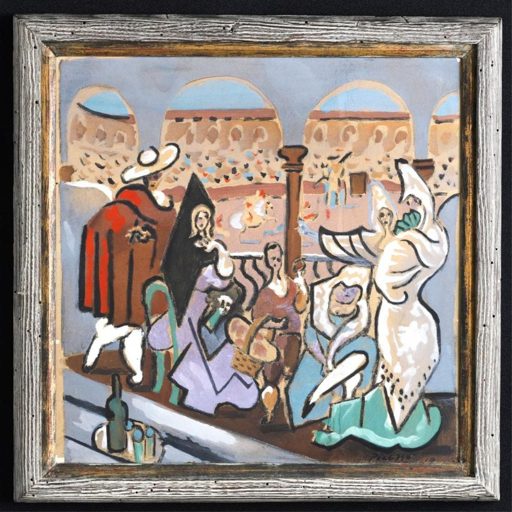

In [7]:
target_url = "https://bostonglobe-prod.cdn.arcpublishing.com/resizer/2-ZvyQ3aRNl_VNo7ja51BM5-Kpk=/960x0/cloudfront-us-east-1.images.arcpublishing.com/bostonglobe/CZOXE32LQQX5UNAB42AOA3SUY4.jpg"

response = requests.get(target_url)
target_image = Image.open(BytesIO(response.content)).convert("RGB")
target_image = target_image.resize((512, 512))
target_image



### Executing the attack
Now we apply the attack to our image

In [ ]:
mask, X = prepare_mask_and_masked_image(init_image, mask_image)
X = X.to(device=device, dtype=torch.float16, non_blocking=True)
mask = mask.to(device=device, dtype=torch.float16, non_blocking=True)

# Here we attack towards the embedding of a random target image. You can also simply attack towards an embedding of zeros!
pipe_inpaint.vae.encoder.to(device=device, non_blocking=True)
pipe_inpaint.vae.quant_conv.to(device=device, non_blocking=True)
target = pipe_inpaint.vae.encode(
    preprocess(target_image
              ).to(device=device, dtype=torch.float16, non_blocking=True)
).latent_dist.mean

# with torch.autograd.profiler.profile(enabled=False, use_cuda=True) as prof:
# torch.cuda.memory._record_memory_history()

adv_X = pgd(
    X,
    target=target,
    model=pipe_inpaint.vae.encode,
    criterion=torch.nn.MSELoss(),
    clamp_min=-1,
    clamp_max=1,
    eps=0.06,
    step_size=0.01,
    iters=1,
    mask=1 - mask
)
# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=100))

adv_X = (adv_X / 2 + 0.5).clamp(0, 1)
# torch.cuda.memory._dump_snapshot("my_snapshot.pickle")


[Running attack]: step size: 0.01: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


In [10]:
raise ValueError("This is a dummy cell to prevent running the following cells")

ValueError: This is a dummy cell to prevent running the following cells

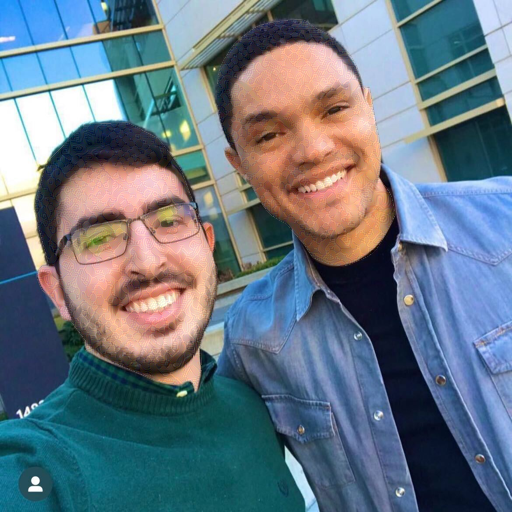

In [ ]:
adv_image = to_pil(adv_X[0]).convert("RGB")
adv_image = recover_image(adv_image, init_image, mask_image, background=True)
adv_image

### Running Stable Diffusion Inpainting
Now that we generated an "immunized"/adversarial image, lets try to run inpainting using stable diffusion on both the original and the adversarial images

In [ ]:
# prompt = "man riding a motorcycle at night"
# prompt = "two men in a wedding"
# prompt = "two men in a restaurant hugging"
# prompt = "two men in a classroom"
# prompt = "two men in a library"
prompt = "two men in the plane hugging"

# A good seed
SEED = 9209

# Uncomment the below to generated other images
# SEED = np.random.randint(low=0, high=100000)

torch.manual_seed(SEED)
print(SEED)

strength = 0.7
guidance_scale = 7.5
num_inference_steps = 100
pipe_inpaint = pipe_inpaint.to(device)
image_nat = pipe_inpaint(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    eta=1,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    strength=strength
).images[0]
image_nat = recover_image(image_nat, init_image, mask_image)

torch.manual_seed(SEED)
image_adv = pipe_inpaint(
    prompt=prompt,
    image=adv_image,
    mask_image=mask_image,
    eta=1,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    strength=strength
).images[0]
image_adv = recover_image(image_adv, init_image, mask_image)

9209


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

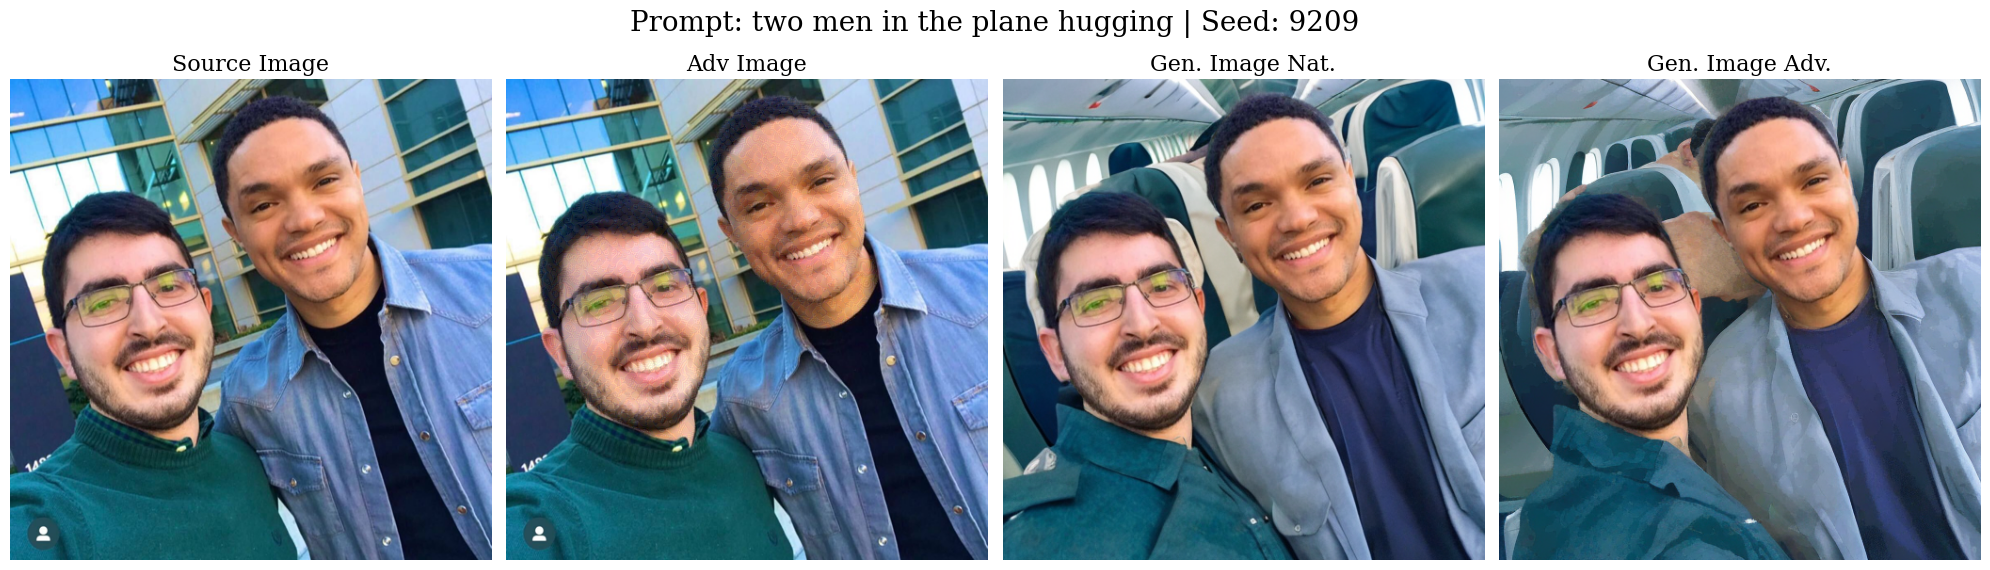

In [ ]:
adv_image = recover_image(adv_image, init_image, mask_image, background=True)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

ax[0].imshow(init_image)
ax[1].imshow(adv_image)
ax[2].imshow(image_nat)
ax[3].imshow(image_adv)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Adv Image', fontsize=16)
ax[2].set_title('Gen. Image Nat.', fontsize=16)
ax[3].set_title('Gen. Image Adv.', fontsize=16)

for i in range(4):
  ax[i].grid(False)
  ax[i].axis('off')

fig.suptitle(f"Prompt: {prompt} | Seed: {SEED}", fontsize=20)
fig.tight_layout()
plt.show()

### Notice how the image generated from the adversarial example is not realistic! For a much stronger attack check `demo_complex_attack_inpainting.ipynb` and compare the results!